In [5]:
!pip install MNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.9 MB/s eta 0:00:00


In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.8 MB/s eta 0:00:00


In [6]:
from google.colab import drive
import os
import mne
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from nilearn.image import clean_img
from nilearn.image import smooth_img
import numpy as np
import pandas as pd

In [7]:
# Manage GPU memory usage to prevent out of memory (OOM) errors
# This makes TensorFlow allocate memory dynamically as needed
try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
  print(f"GPU is available: {physical_devices}")
except:
  print("No GPU Found or TensorFlow Unable To Allocate Memory Dynamically.")

No GPU Found or TensorFlow Unable To Allocate Memory Dynamically.


**Access Google Drive in Google Colab**

In [8]:
drive.mount('/content/drive/',force_remount=True)

# OpenNeuro dataset
dataset_path_eeg_rest_state = '/content/drive/MyDrive/AI-BNDP_Prediction/data/eeg_rest_state_Parkinson/'

#PhysioNet EEG dataset
dataset_path_eegmotor = '/content/drive/MyDrive/AI-BNDP_Prediction/data/eeg_motor_movement/'

#fMRI dataset
dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'

Mounted at /content/drive/


In [9]:
print(f"Dataset of UC San Diego Resting State EEG Data from Patients with Parkinson's Disease:{os.listdir(dataset_path_eeg_rest_state)}\n")
print(f"Dataset of EEG Motor Movement/Imagery Dataset: {os.listdir(dataset_path_eegmotor)}\n")
print(f"Dataset of Parkinson's disease functional connectivity, and cognition {os.listdir(dataset_path_fmri_parkinson)}\n")

Dataset of UC San Diego Resting State EEG Data from Patients with Parkinson's Disease:['CHANGES', 'participants.tsv', 'README', 'participants.json', 'dataset_description.json', 'task-rest_beh.json', '.DS_Store', 'sub-hc31', 'sub-pd23', 'sub-pd3', 'sub-pd5', 'sub-hc2', 'sub-hc24', 'sub-pd12', 'sub-hc30', 'sub-hc25', 'sub-hc4', 'sub-pd13', 'sub-hc21', 'sub-hc20', 'sub-hc18', 'sub-hc1', 'sub-pd22', 'sub-hc7', 'sub-hc10', 'sub-pd14', 'sub-hc8', 'sub-pd16', 'sub-pd6', 'sub-pd9', 'sub-hc33', 'sub-hc32', 'sub-pd11', 'sub-pd28', 'sub-pd19', 'sub-hc29', 'sub-pd17', 'sub-pd26']

Dataset of EEG Motor Movement/Imagery Dataset: ['wfdbcal', 'ANNOTATORS', '64_channel_sharbrough.pdf', '64_channel_sharbrough-old.png', '64_channel_sharbrough.png', 'RECORDS', 'SHA256SUMS.txt', '.DS_Store', 'S031', 'S062', 'S007', 'S096', 'S091', 'S009', 'S038', 'S036', 'S065', 'S006', 'S030', 'S039', 'S098', 'S054', 'S037', 'S001', 'S055', 'S053', 'S008', 'S079', 'S052', 'S064', 'S084', 'S046', 'S041', 'S063', 'S090', 'S

**Loading and Visualizing the fMRI Data**
1. Before we dive into functional connectivity analysis or machine learning, we need to ensure the fMRI data is loaded correctly, and we have a clear understanding of its structure and dimensions.

2. Visualizing the fMRI data helps us inspect its quality and spatial resolution before proceeding with preprocessing steps like motion correction and filtering.

**List the fMRI Files**

In [10]:
#List the files in the fMRI dataset folder

dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'
fmri_subjects = os.listdir(dataset_path_fmri_parkinson)
print(f"Subjects in fMRI Dataset: {fmri_subjects}")

Subjects in fMRI Dataset: ['CHANGES', 'README', 'participants.json', 'dataset_description.json', 'participants.tsv', '.DS_Store', 'sub-2140', 'sub-0227', 'sub-0272', 'sub-0243', 'sub-2141', 'sub-0226', 'sub-2122', 'sub-0210', 'sub-2125', 'sub-0242', 'sub-2137', 'sub-2148', 'sub-0250', 'sub-0204', 'sub-2139', 'sub-0203', 'sub-2130', 'sub-0257', 'sub-0232', 'sub-0235', 'sub-2154', 'sub-0258', 'sub-0234', 'sub-2136', 'sub-2131', 'sub-0233', 'sub-0205', 'sub-0202', 'sub-0256', 'sub-0267', 'sub-2128', 'sub-0249', 'sub-0270', 'sub-2145', 'sub-0240', 'sub-0212', 'phenotype', 'sub-0247', 'sub-0224', 'sub-0246', 'sub-0231', 'sub-0209', 'sub-0265', 'sub-2134', 'sub-0238', 'sub-2129', 'sub-0222', 'sub-0213', 'sub-0207', 'sub-0214', 'sub-0264', 'sub-0230', 'sub-0263', 'sub-0237', 'sub-0253', 'sub-0252', 'sub-0206', 'sub-0255', 'sub-2132', 'data']


**Load the fMRI Data**

fMRI Data Shape:(64, 64, 34, 300)


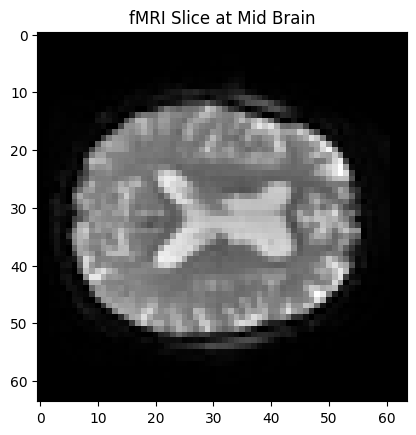

In [11]:
# Example fMRI file path
fmri_file = dataset_path_fmri_parkinson + 'sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii.gz'

#Load the fMRI data of that file using NiBabel
fmri_img = nib.load(fmri_file)

# Get the fMRI data as numPy array
fmri_data = fmri_img.get_fdata()

#print the shape of the fMRI data (width x height x depth x timepoints)
print(f"fMRI Data Shape:{fmri_data.shape}")

# Visualize a slice of the fMRI data
plt.imshow(fmri_data[:,:,fmri_data.shape[2] // 2, 0], cmap = 'gray')
plt.title('fMRI Slice at Mid Brain')
plt.show()

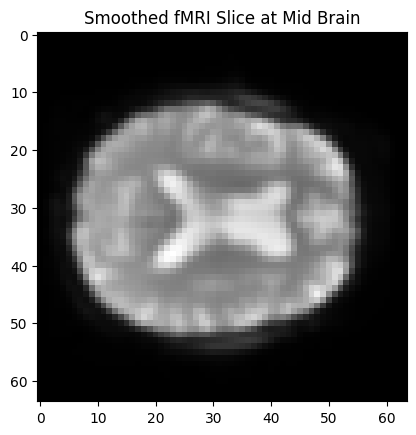

In [ ]:
# Apply spatial smoothing (e.g., 6mm smoothing kernel)
smoothed_fmri_img = smooth_img(fmri_img, fwhm=6)

# Extract the smoothed data
smoothed_fmri_data = smoothed_fmri_img.get_fdata()

# Visualize a slice of the smoothed fMRI data
plt.imshow(smoothed_fmri_data[:, :, smoothed_fmri_data.shape[2] // 2, 0], cmap='gray')
plt.title('Smoothed fMRI Slice at Mid Brain')
plt.show()


In [ ]:
"""# Path to the main fMRI dataset folder
dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'

# Define a new folder for the cleaned data
cleaned_data_folder = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/'

# Create the cleaned data folder if it doesn't exist
os.makedirs(cleaned_data_folder, exist_ok=True)

# Loop through each subject folder
for subject in os.listdir(dataset_path_fmri_parkinson):
    # Check if the folder name starts with 'sub-'
    if subject.startswith('sub-'):
        # Path to the func folder for the subject
        func_folder_path = os.path.join(dataset_path_fmri_parkinson, subject, 'ses-01', 'func')

        # Find the .nii.gz file inside the func folder
        for file in os.listdir(func_folder_path):
            if file.endswith('.nii.gz'):
                # Full path to the original fMRI file
                fmri_file_path = os.path.join(func_folder_path, file)

                # Load the fMRI image
                fmri_img = nib.load(fmri_file_path)

                # Apply motion correction and filtering
                cleaned_fmri_img = clean_img(
                    fmri_img,
                    detrend=True,
                    standardize=True,
                    low_pass=0.1,
                    high_pass=0.01,
                    t_r=2.0
                )

                # Define the output path in the cleaned data folder
                cleaned_output_path = os.path.join(cleaned_data_folder, f'{subject}_cleaned.nii.gz')

                # Save the cleaned data in the cleaned folder
                cleaned_fmri_img.to_filename(cleaned_output_path)

                print(f"Processed and saved cleaned fMRI data for subject: {subject} in {cleaned_data_folder}")
"""

'# Path to the main fMRI dataset folder\ndataset_path_fmri_parkinson = \'/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/\'\n\n# Define a new folder for the cleaned data\ncleaned_data_folder = \'/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/\'\n\n# Create the cleaned data folder if it doesn\'t exist\nos.makedirs(cleaned_data_folder, exist_ok=True)\n\n# Loop through each subject folder\nfor subject in os.listdir(dataset_path_fmri_parkinson):\n    # Check if the folder name starts with \'sub-\'\n    if subject.startswith(\'sub-\'):\n        # Path to the func folder for the subject\n        func_folder_path = os.path.join(dataset_path_fmri_parkinson, subject, \'ses-01\', \'func\')\n        \n        # Find the .nii.gz file inside the func folder\n        for file in os.listdir(func_folder_path):\n            if file.endswith(\'.nii.gz\'):\n                # Full path to the original fMRI file\n                fmri_file_path = os.path.join(func_folder_path, fil

Why Extract Time-Series Data?

The goal of functional connectivity analysis is to understand how different regions of the brain communicate over time.

To do this, we need to define Regions of Interest (ROIs) in the brain and then extract the average signal (time-series) for each ROI across the entire scan.
This time-series data will allow us to calculate correlations between regions, which is the basis for functional connectivity.

How to Extract Time-Series Data?

To extract time-series data from specific regions, we’ll use a brain atlas. A brain atlas divides the brain into anatomical or functional regions, each representing a distinct area of interest.

Choose a Brain Atlas:

Common atlases include the AAL (Automated Anatomical Labeling), Harvard-Oxford, or Schaefer atlas. These atlases can be downloaded and are compatible with packages like Nilearn.
Load the Atlas and Extract Regions:

Load the atlas, which defines different ROIs in the brain.
Use the atlas to extract the average time-series for each region in the cleaned fMRI data.

In [ ]:
from nilearn import datasets, image, masking
from nilearn.input_data import NiftiLabelsMasker
import pickle
import os

In [ ]:
#path to save/load the time series data
time_series_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/time_series_data.pkl'


#check if the time-series data file already exists
if os.path.exists(time_series_data_file):
  #load the time-series data from the file
  with open(time_series_data_file, 'rb') as file:
    time_series_data = pickle.load(file)
  print("Loaded time-series data from file.")
else:
  #Run this block only if the file does not exist

  #load an atlas
  atlas = datasets.fetch_atlas_aal()
  atlas_filename = atlas.maps

  #initilize the masker with the atlas
  masker = NiftiLabelsMasker(labels_img=atlas_filename,standardize=True, t_r=2.0)

  #Path to the cleaned data folder
  cleaned_data_folder = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/'

  time_series_data = {}

  #loop through each cleaned fMRI file and extract time-series data
  for file in os.listdir(cleaned_data_folder):
    if file.endswith('_cleaned.nii.gz'):
      subject_id = file.split('_')[0] #extract subject ID from file name
      cleaned_fmri_path = os.path.join(cleaned_data_folder,file)

      #Extract time-series for each region using atlas
      time_series = masker.fit_transform(cleaned_fmri_path)

      #store the time series data
      time_series_data[subject_id] = time_series

      print(f"Extracted Time-series data for subject: {subject_id}")

    #save the extracted data to the file
    with open(time_series_data_file,'wb') as file:
      pickle.dump(time_series_data,file)
    print("Saved time-series data to file")

  #Example: Access time-series for a specific subject
  example_subject_id = list(time_series_data.keys())[0]
  print(f"time-series shape for {example_subject_id}: {time_series_data[example_subject_id].shape}")

Loaded time-series data from file.


**Analyze functional connectivity**

**Step-1: Calculate the Functional Connectivity Matrix**

The goal of functional connectivity analysis is to understand how brain regions are related. We do this by calculating the correlation between the time-series data of each pair of regions. This results in a connectivity matrix where each cell shows how strongly two regions are connected.

What is a Functional Connectivity Matrix?

It’s a matrix where:
Rows and columns represent different brain regions.
Each cell in the matrix shows the correlation between the time-series of two regions.
This matrix tells us which regions are "communicating" or showing synchronized activity.

Computed functional connectivity matrix for subject: sub-2140


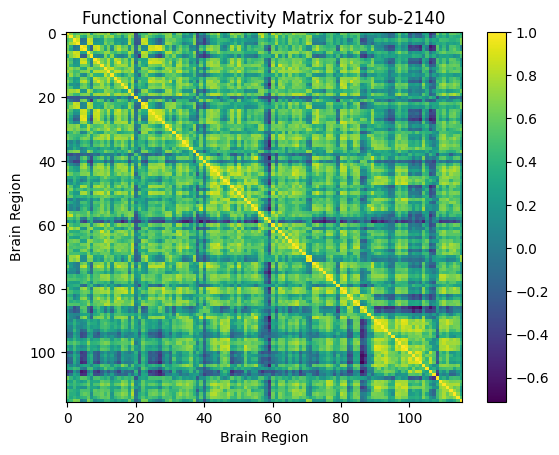

Computed functional connectivity matrix for subject: sub-0227
Computed functional connectivity matrix for subject: sub-0272
Computed functional connectivity matrix for subject: sub-0243
Computed functional connectivity matrix for subject: sub-2141
Computed functional connectivity matrix for subject: sub-0226
Computed functional connectivity matrix for subject: sub-2122
Computed functional connectivity matrix for subject: sub-0210
Computed functional connectivity matrix for subject: sub-2125
Computed functional connectivity matrix for subject: sub-0242
Computed functional connectivity matrix for subject: sub-2137
Computed functional connectivity matrix for subject: sub-2148
Computed functional connectivity matrix for subject: sub-0250
Computed functional connectivity matrix for subject: sub-0204
Computed functional connectivity matrix for subject: sub-2139
Computed functional connectivity matrix for subject: sub-0203
Computed functional connectivity matrix for subject: sub-2130
Computed

In [ ]:
#Dictionary to store functional connectivity matrices for each subject
functional_connectivity_matrices = {}

for subject_id, time_series in time_series_data.items():
  #calc the pearson correlation matrix for time_series_data
  connectivity_matrix = np.corrcoef(time_series,rowvar=False)

  #store the connectivity matrix
  functional_connectivity_matrices[subject_id] = connectivity_matrix

  print(f"Computed functional connectivity matrix for subject: {subject_id}")

  #Optional: Visualize the connectivity matrix for one subject
  if subject_id == "sub-2140": #we can change to any subject we like
    plt.imshow(connectivity_matrix, cmap='viridis',aspect="auto")
    plt.colorbar()
    plt.title(f"Functional Connectivity Matrix for {subject_id}")
    plt.xlabel("Brain Region")
    plt.ylabel("Brain Region")
    plt.show()



**What This Data Represents**
This data combines two main types of information:

Functional Connectivity Data:

This part of the data shows how different regions in the brain “talk” to each other. Each subject's brain activity was measured using fMRI (functional Magnetic Resonance Imaging) while they were at rest.
We took these fMRI measurements and calculated a connectivity matrix for each subject. This matrix shows how brain regions are correlated (how similar their activity patterns are).

The connectivity matrix was then "flattened" into a single long list of numbers (a sequence) for each subject, which allows us to use it as input for machine learning models.

Cognitive Scores:

This part contains scores that measure different aspects of each subject’s cognitive (thinking) abilities.
There are several cognitive categories, including attention, executive function (decision-making skills), memory, language, visuospatial ability (understanding visual information), and global cognition (overall cognitive ability).
These scores help us understand each subject's mental abilities. Some scores may be high (better ability), while others may be lower (indicating cognitive challenges).

**Why We Combine These Two Types of Data**

By combining brain connectivity data with cognitive scores, we’re trying to find patterns between how the brain’s connectivity might relate to different cognitive abilities or impairments.

**For example:**

If certain brain regions don’t communicate well together (low connectivity), it might be linked to lower scores in memory or attention.
If there are specific patterns in connectivity associated with high scores in attention or executive function, we may be able to predict these scores just from brain connectivity.

In [ ]:
# Path to the cognitive domains file
cognitive_scores_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/phenotype/cognitive_domains.tsv'


# Load cognitive scores into a DataFrame
cognitive_scores_df = pd.read_csv(cognitive_scores_file, sep='\t')

In [ ]:
# Remove 'sub-' prefix from both functional connectivity and cognitive scores data
adjusted_flattened_sequences = {subject_id.replace('sub-', '').zfill(4): sequence for subject_id, sequence in flattened_sequences.items()}
cognitive_scores_df['participant_id'] = cognitive_scores_df['participant_id'].str.replace('sub-', '').str.zfill(4)

# Display adjusted IDs to verify formatting
print("Adjusted Participant IDs in Functional Connectivity Data:", list(adjusted_flattened_sequences.keys())[:10])
print("Adjusted Participant IDs in Cognitive Scores Data:", list(cognitive_scores_df['participant_id'])[:10])

# Now align the scores with the functional connectivity data
aligned_data = []
for subject_id, flattened_sequence in adjusted_flattened_sequences.items():
    # Check if the subject exists in cognitive scores data
    if subject_id in cognitive_scores_df['participant_id'].values:
        # Get the cognitive scores for this subject
        scores = cognitive_scores_df[cognitive_scores_df['participant_id'] == subject_id].iloc[0]

        # Create a combined record of the connectivity data and cognitive scores
        record = {
            'subject_id': subject_id,
            'connectivity': flattened_sequence,
            'attention': scores['attention'],
            'executive': scores['executive'],
            'global': scores['global'],
            'language': scores['language'],
            'memory': scores['memory'],
            'visuospatial': scores['visuospatial']
        }
        aligned_data.append(record)

# Convert the aligned data into a DataFrame
aligned_df = pd.DataFrame(aligned_data)

# Check the shape and sample of the aligned data
print("Aligned data shape:", aligned_df.shape)
print("Sample of aligned data:")
print(aligned_df.head())

# Save the aligned data
aligned_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores.pkl'
aligned_df.to_pickle(aligned_data_file)
print(f"Aligned data saved to {aligned_data_file}")


Adjusted Participant IDs in Functional Connectivity Data: ['2140', '0227', '0272', '0243', '2141', '0226', '2122', '0210', '2125', '0242']
Adjusted Participant IDs in Cognitive Scores Data: ['0202', '0203', '0204', '0205', '0206', '0207', '0209', '0210', '0212', '0213']
Aligned data shape: (58, 8)
Sample of aligned data:
  subject_id                                       connectivity  attention  \
0       2140  [0.9999999999999998, 0.7049516665506806, 0.492...   -6.50641   
1       0227  [1.0, 0.7264209794122581, 0.8180159291506557, ...    0.46127   
2       0272  [1.0, 0.860733695745355, 0.6675504917150709, 0...   -0.10250   
3       0243  [1.0, 0.734537712346681, 0.7213373609503154, 0...   -0.51577   
4       2141  [0.9999999999999998, 0.8848666398099524, 0.876...   -1.87683   

   executive   global  language   memory  visuospatial  
0   -5.53550 -1.83354  -0.31628 -1.45186           NaN  
1    0.28529 -1.05937  -0.44558  1.29787      0.601817  
2    0.13668  0.00046   0.58319 -0.47

In [ ]:
aligned_df

,subject_id,connectivity,attention,executive,global,language,memory,visuospatial
0,2140,"[0.9999999999999998, 0.7049516665506806, 0.492...",-6.50641,-5.53550,-1.83354,-0.31628,-1.45186,NaN
1,0227,"[1.0, 0.7264209794122581, 0.8180159291506557, ...",0.46127,0.28529,-1.05937,-0.44558,1.29787,0.601817
2,0272,"[1.0, 0.860733695745355, 0.6675504917150709, 0...",-0.10250,0.13668,0.00046,0.58319,-0.47284,0.601817
3,0243,"[1.0, 0.734537712346681, 0.7213373609503154, 0...",-0.51577,-0.31111,-0.07869,1.29519,-0.66063,0.014244
4,2141,"[0.9999999999999998, 0.8848666398099524, 0.876...",-1.87683,-3.10264,-4.00268,-3.63133,-3.07207,NaN
5,0226,"[0.9999999999999998, 0.6335642915247438, 0.811...",0.57903,0.71350,0.79255,0.65642,0.73172,0.405959
6,2122,"[0.9999999999999998, 0.5453707672223519, 0.765...",-0.03324,0.19036,1.20065,0.39467,1.07187,0.405959
7,0210,"[1.0, 0.984128181100264, 0.9846278632289283, 0...",0.61256,0.93263,0.62807,0.30847,0.61987,1.189390
8,2125,"[0.9999999999999998, 0.7052784555368062, 0.818...",0.19318,0.17058,0.17731,0.97528,0.58213,-0.377471
9,0242,"[1.0, 0.8348938082512464, 0.7952166596214039, ...",0.68735,0.65499,0.90818,0.64240,-0.28412,-0.181613


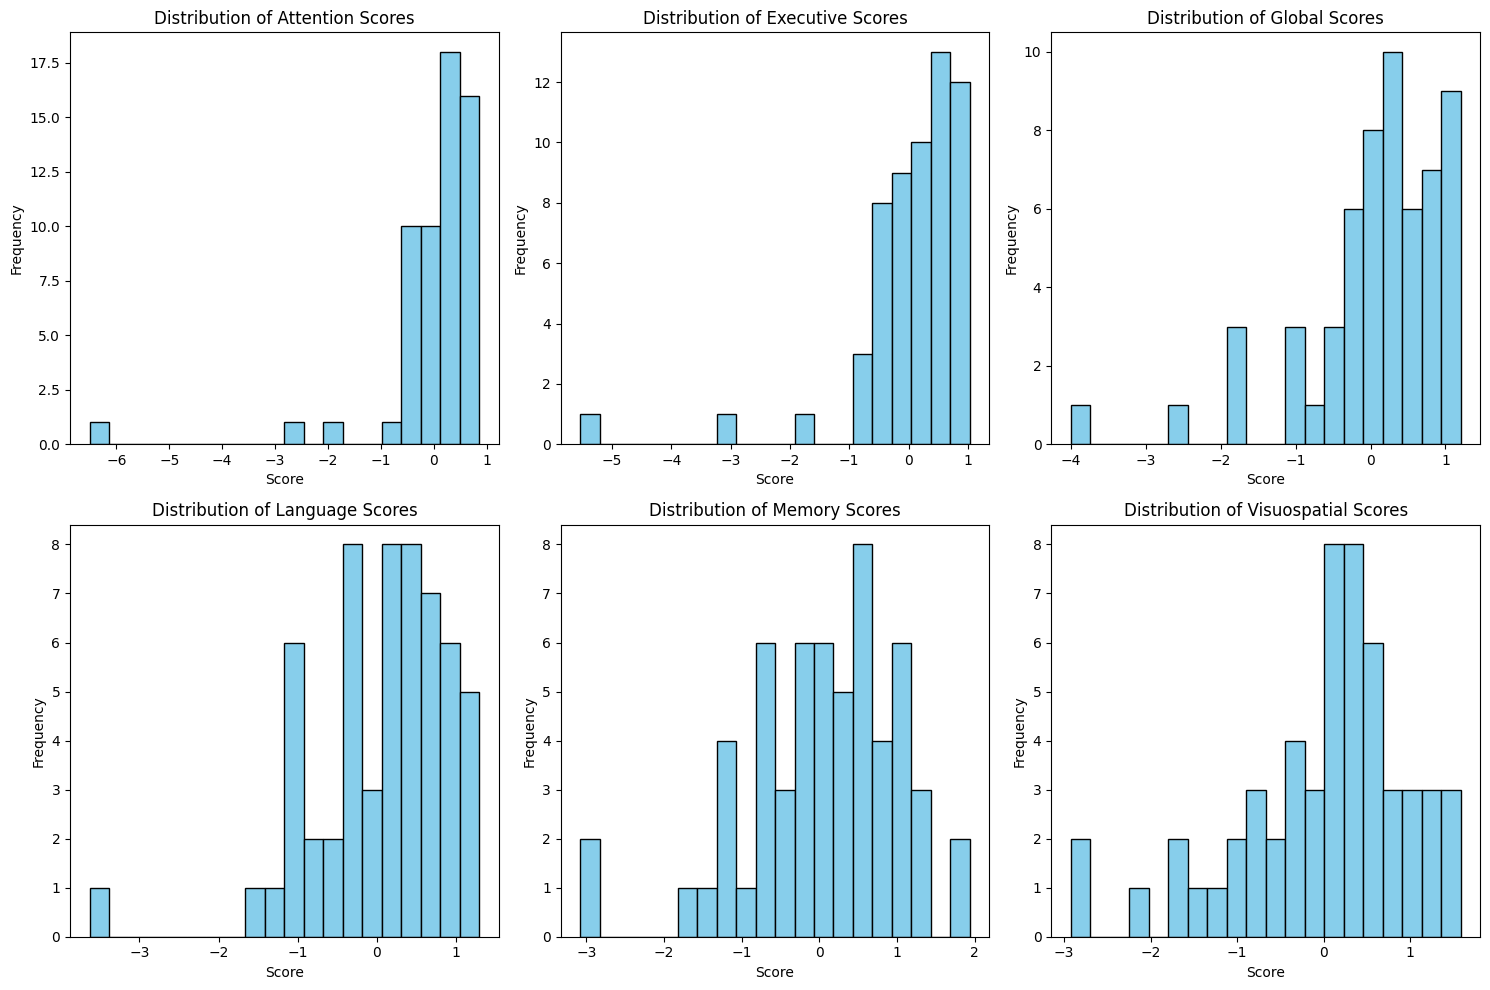

In [ ]:
import matplotlib.pyplot as plt

# List of cognitive domains to visualize
cognitive_domains = ['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']

# Set up the plot grid
plt.figure(figsize=(15, 10))

# Plot each domain's distribution
for i, domain in enumerate(cognitive_domains, 1):
    plt.subplot(2, 3, i)  # Arrange plots in 2 rows and 3 columns
    plt.hist(aligned_df[domain].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {domain.capitalize()} Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


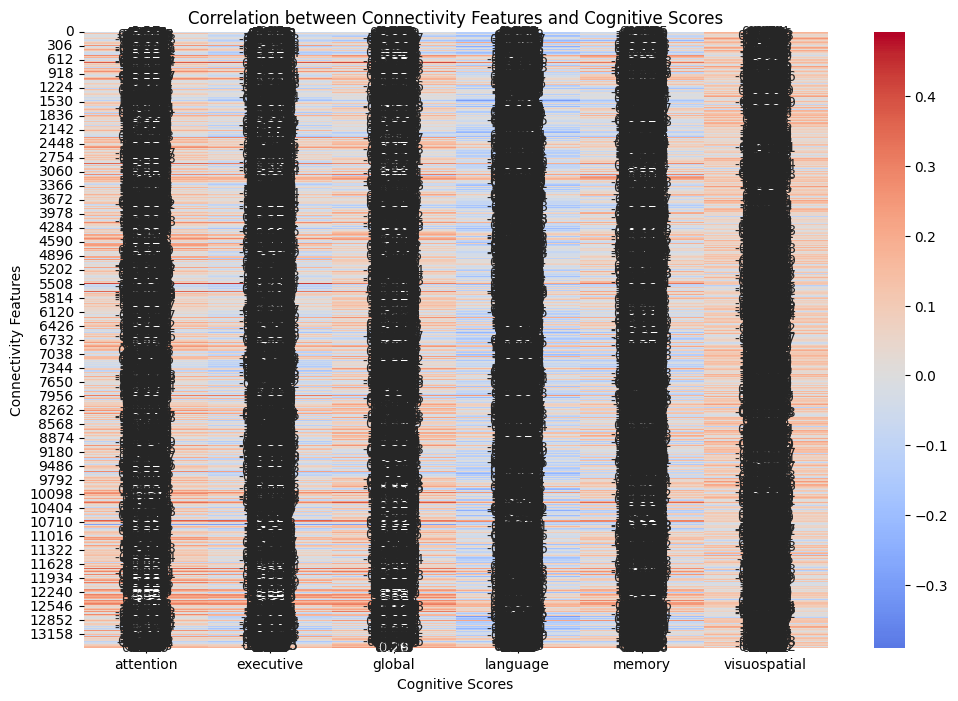

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the flattened connectivity data and cognitive scores to a DataFrame for analysis
connectivity_df = pd.DataFrame(aligned_df['connectivity'].tolist())
scores_df = aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']]

# Combine both DataFrames
combined_df = pd.concat([connectivity_df, scores_df.reset_index(drop=True)], axis=1)

# Calculate correlation matrix between connectivity features and cognitive scores
correlation_matrix = combined_df.corr().iloc[:connectivity_df.shape[1], -scores_df.shape[1]:]

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Connectivity Features and Cognitive Scores")
plt.xlabel("Cognitive Scores")
plt.ylabel("Connectivity Features")
plt.show()


<Figure size 1500x1000 with 0 Axes>

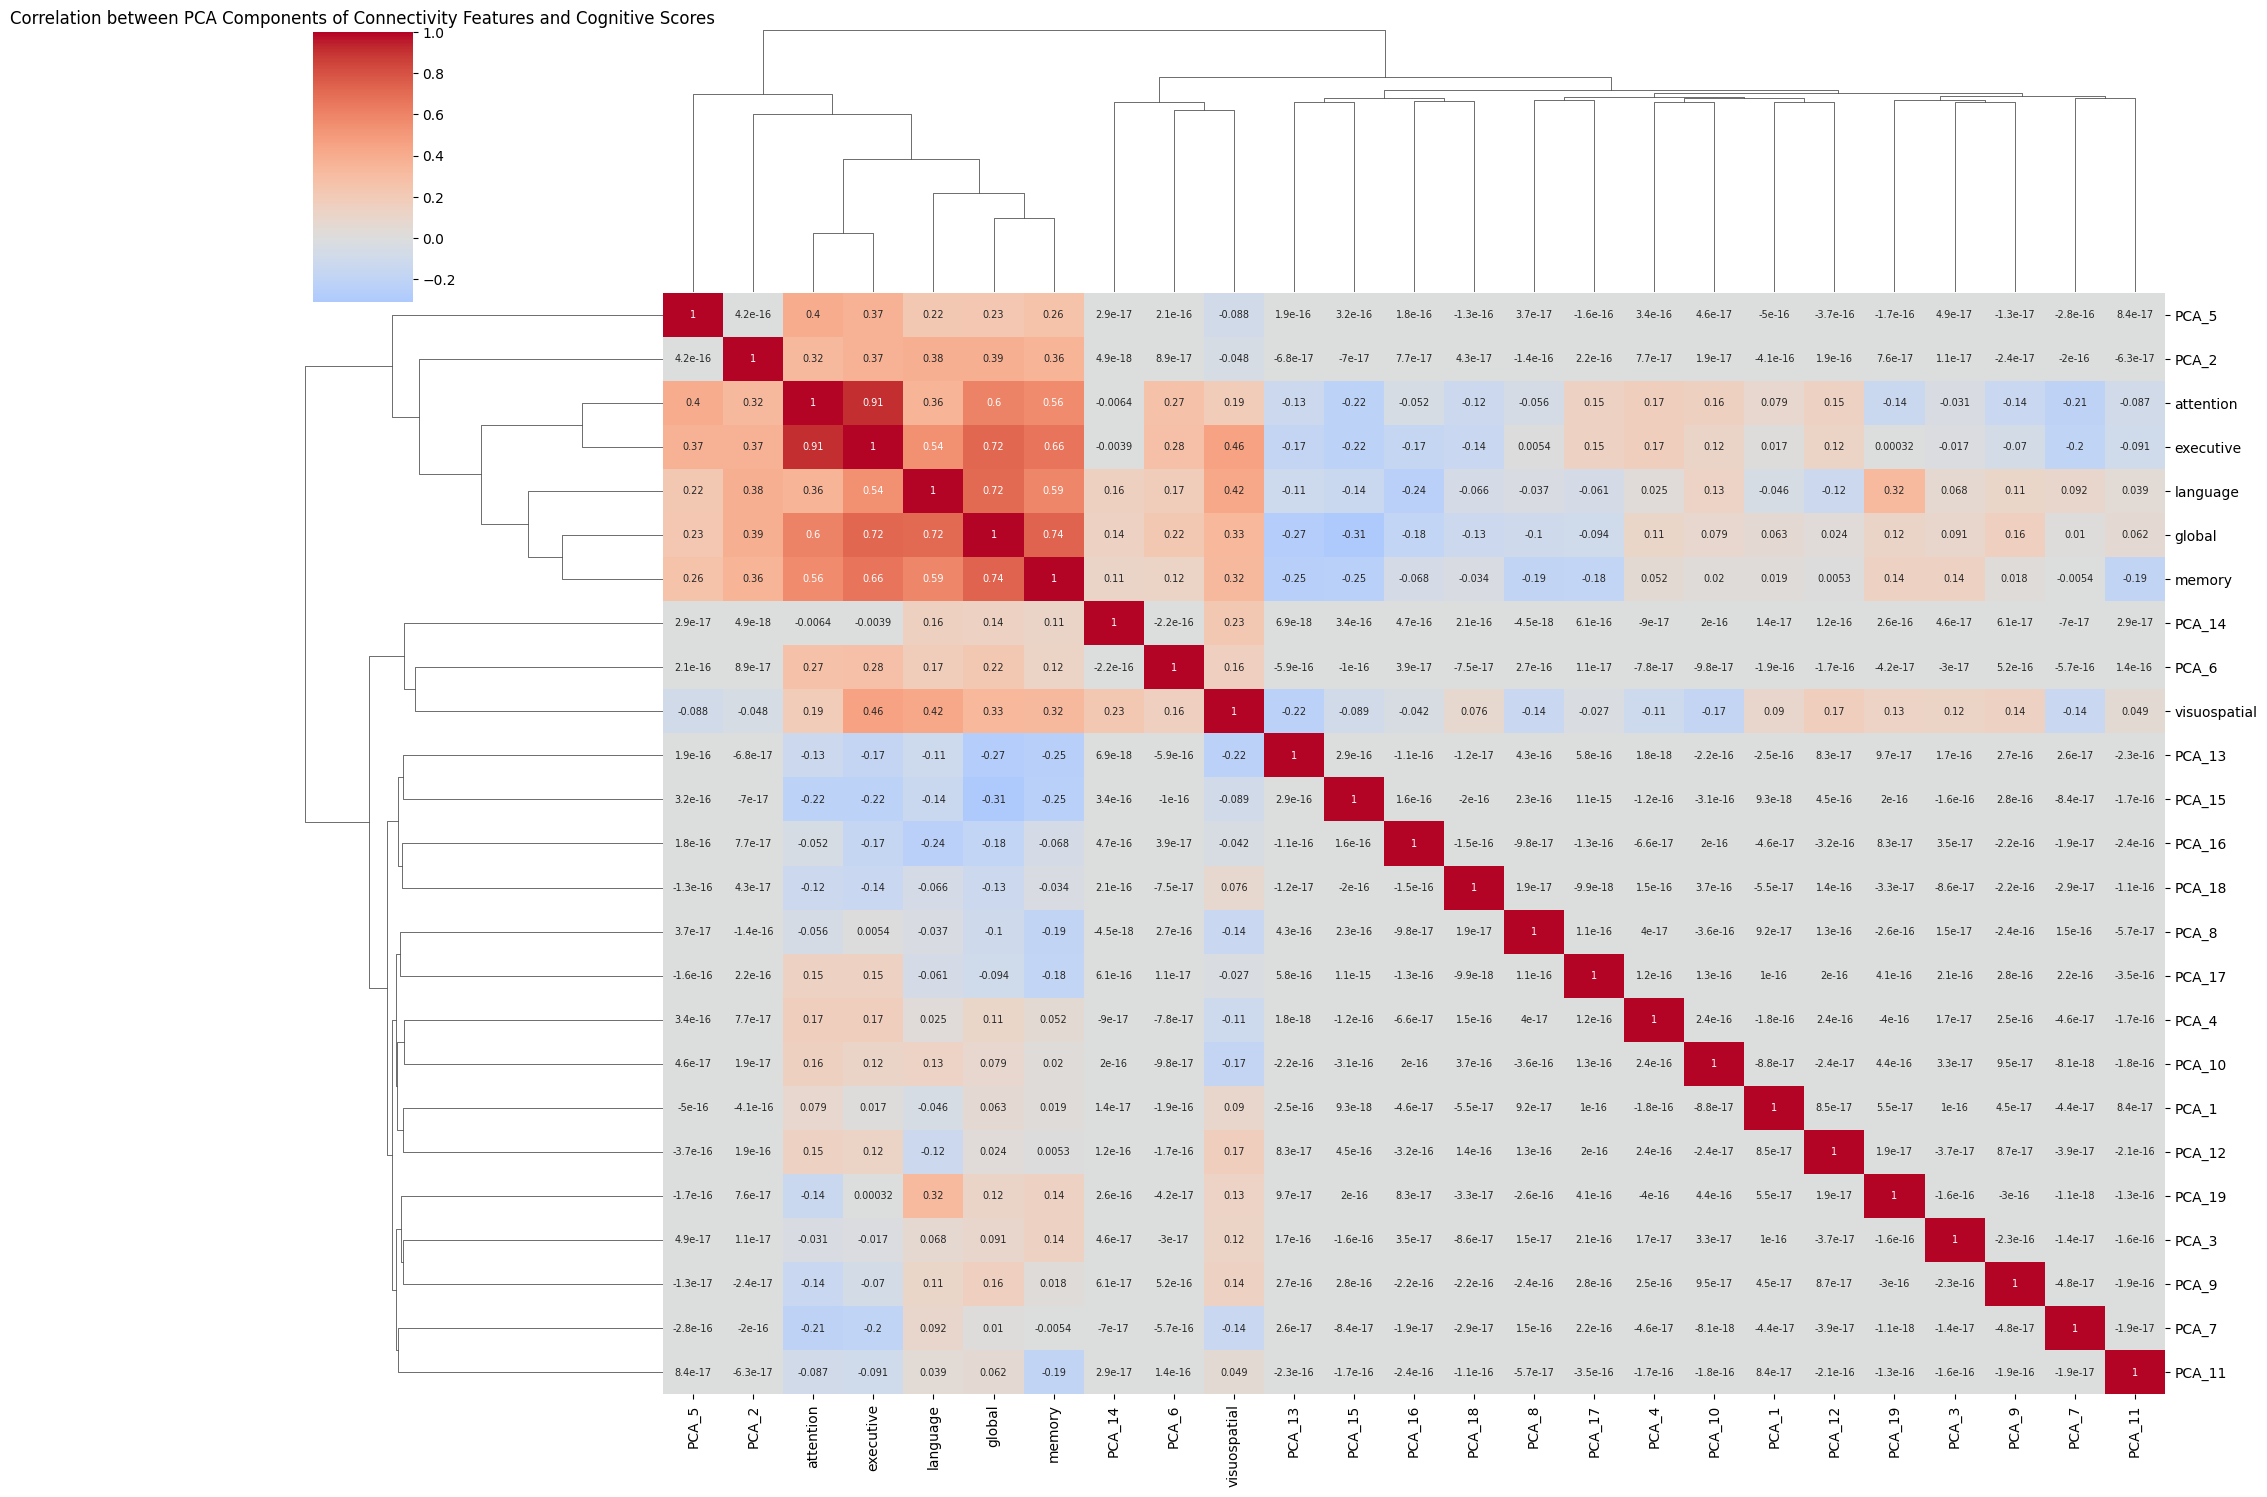

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Perform PCA on the connectivity features
# Extract connectivity features only
connectivity_features = aligned_df['connectivity'].tolist()
connectivity_features = np.array(connectivity_features)

# Apply PCA to reduce dimensions while retaining 90% variance
pca = PCA(n_components=0.90)
reduced_connectivity = pca.fit_transform(connectivity_features)

# Step 2: Combine reduced PCA components with cognitive scores
# Create a DataFrame for the reduced connectivity features
pca_df = pd.DataFrame(reduced_connectivity, columns=[f'PCA_{i+1}' for i in range(reduced_connectivity.shape[1])])

# Add cognitive scores to this DataFrame
cognitive_scores = aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']].reset_index(drop=True)
combined_df = pd.concat([pca_df, cognitive_scores], axis=1)

# Step 3: Calculate correlations
correlation_matrix = combined_df.corr()

# Adjust the plot with a larger figure, rotated labels, and smaller annotations
plt.figure(figsize=(15, 10))  # Increase figure size
sns.clustermap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    figsize=(20, 15),  # Larger figure size
    annot_kws={"size": 7},  # Smaller font size for annotations
    xticklabels=1,  # Show all x-axis labels
    yticklabels=1  # Show all y-axis labels
)

plt.title("Correlation between PCA Components of Connectivity Features and Cognitive Scores")
plt.show()



In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# Load the aligned data without PCA (replace with your actual path)
aligned_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores.pkl'
aligned_df = pd.read_pickle(aligned_data_file)

# Extract the connectivity features for PCA
connectivity_features = aligned_df['connectivity'].tolist()
connectivity_matrix = pd.DataFrame(connectivity_features)

# Apply PCA to the connectivity matrix
pca = PCA(n_components=20)  # Adjust the number of components if needed
pca_components = pca.fit_transform(connectivity_matrix)

# Convert PCA components to a DataFrame
pca_df = pd.DataFrame(pca_components, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[1])])

# Add the PCA components to the aligned data
aligned_df_with_pca = pd.concat([aligned_df, pca_df], axis=1)

# Save the new DataFrame with PCA components
aligned_pca_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores_with_pca.pkl'
aligned_df_with_pca.to_pickle(aligned_pca_file)

print(f"Aligned data with PCA components saved to {aligned_pca_file}")


Aligned data with PCA components saved to /content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores_with_pca.pkl


In [ ]:
import pandas as pd

# Load the aligned data with PCA components and cognitive scores (replace with your actual path)
aligned_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores_with_pca.pkl'
aligned_df = pd.read_pickle(aligned_data_file)

# Select only the PCA components that are relevant (PCA_2, PCA_5, PCA_1) and cognitive scores
selected_components = ['PCA_2', 'PCA_5', 'PCA_1']
cognitive_scores = ['attention', 'executive', 'language', 'global', 'memory', 'visuospatial']
selected_df = aligned_df[selected_components + cognitive_scores]

# Display the selected data
print("Selected Data for Modeling:")
print(selected_df.head())


Selected Data for Modeling:
      PCA_2      PCA_5      PCA_1  attention  executive  language   global  \
0 -8.203070 -10.527053  -5.152932   -6.50641   -5.53550  -0.31628 -1.83354   
1  3.739741   3.524248 -11.151929    0.46127    0.28529  -0.44558 -1.05937   
2 -8.803892  -0.137561 -10.031441   -0.10250    0.13668   0.58319  0.00046   
3 -5.784078   2.434510 -17.592226   -0.51577   -0.31111   1.29519 -0.07869   
4 -6.782074 -11.860051 -10.370400   -1.87683   -3.10264  -3.63133 -4.00268   

    memory  visuospatial  
0 -1.45186           NaN  
1  1.29787      0.601817  
2 -0.47284      0.601817  
3 -0.66063      0.014244  
4 -3.07207           NaN  


In [ ]:
# Select only numeric columns for calculating the median and filling NaN values
numeric_cols = aligned_df_with_pca.select_dtypes(include=[np.number]).columns
aligned_df_with_pca[numeric_cols] = aligned_df_with_pca[numeric_cols].fillna(aligned_df_with_pca[numeric_cols].median())

# Display the updated DataFrame to confirm missing values have been handled
print(aligned_df_with_pca.head())



  subject_id                                       connectivity  attention  \
0       2140  [0.9999999999999998, 0.7049516665506806, 0.492...   -6.50641   
1       0227  [1.0, 0.7264209794122581, 0.8180159291506557, ...    0.46127   
2       0272  [1.0, 0.860733695745355, 0.6675504917150709, 0...   -0.10250   
3       0243  [1.0, 0.734537712346681, 0.7213373609503154, 0...   -0.51577   
4       2141  [0.9999999999999998, 0.8848666398099524, 0.876...   -1.87683   

   executive   global  language   memory  visuospatial      PCA_1     PCA_2  \
0   -5.53550 -1.83354  -0.31628 -1.45186      0.210102  -5.152932 -8.203070   
1    0.28529 -1.05937  -0.44558  1.29787      0.601817 -11.151929  3.739741   
2    0.13668  0.00046   0.58319 -0.47284      0.601817 -10.031441 -8.803892   
3   -0.31111 -0.07869   1.29519 -0.66063      0.014244 -17.592226 -5.784078   
4   -3.10264 -4.00268  -3.63133 -3.07207      0.210102 -10.370400 -6.782074   

   ...    PCA_11    PCA_12    PCA_13    PCA_14    PCA_15

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define X as the PCA components and y as the cognitive scores
X = aligned_df_with_pca.filter(regex='^PCA')  # Selecting all columns that start with 'PCA'
y = aligned_df_with_pca[['attention', 'executive', 'language', 'global', 'memory', 'visuospatial']]

# Standardize the cognitive scores (target variables)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

# Create a new DataFrame for the scaled cognitive scores, keeping the original column names
y_scaled_df = pd.DataFrame(y_scaled, columns=y.columns)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled_df, test_size=0.2, random_state=42)

# Print out a sample of the standardized cognitive scores to verify
print("Sample of standardized cognitive scores:")
print(y_scaled_df.head())



Sample of standardized cognitive scores:
   attention  executive  language    global    memory  visuospatial
0  -6.181012  -5.489001 -0.436806 -1.959711 -1.456648      0.206242
1   0.448881   0.252320 -0.586978 -1.159329  1.254090      0.611735
2  -0.087558   0.105739  0.607856 -0.063615 -0.491511      0.611735
3  -0.480793  -0.335938  1.434788 -0.145445 -0.676638      0.003496
4  -1.775870  -3.089356 -4.286972 -4.202294 -3.053882      0.206242


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming aligned_df_with_pca is already loaded, select features for X and y
X = aligned_df_with_pca.filter(regex='^PCA').values  # Selecting all columns that start with 'PCA'
y = aligned_df_with_pca[['attention', 'executive', 'language', 'global', 'memory', 'visuospatial']].values

# Fill any remaining NaNs in y with column medians
y = np.nan_to_num(y, nan=np.nanmedian(y))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X to be compatible with LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Standardize X (features) and y (targets) for stability
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Flatten X for scaling, then reshape back to 3D
X_train_scaled = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_x.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Standardize y for LSTM compatibility
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# LSTM Model definition
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Match output layer to y's feature count
])

# Compile the model with a low learning rate for stability
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Make predictions on validation set
y_pred_scaled = model.predict(X_val_scaled)

# Inverse scale the predictions and true values to get back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_orig = scaler_y.inverse_transform(y_val_scaled)

# Calculate Mean Squared Error on validation data
mse = mean_squared_error(y_val_orig, y_pred)
print(f"Validation Mean Squared Error: {mse}")

# Check for NaNs in predictions and validation data (as a final diagnostic step)
print(f"NaN values in y_val_orig: {np.isnan(y_val_orig).sum()}")
print(f"NaN values in y_pred: {np.isnan(y_pred).sum()}")

if np.isnan(y_pred).any() or np.isnan(y_val_orig).any():
    print("Warning: NaNs detected in either y_val_orig or y_pred. Please check data preprocessing steps.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.9973 - val_loss: 2.7464
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9905 - val_loss: 2.7463
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9890 - val_loss: 2.7463
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9869 - val_loss: 2.7462
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9901 - val_loss: 2.7462
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9880 - val_loss: 2.7461
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9869 - val_loss: 2.7461
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9892 - val_loss: 2.7460
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9890 - val_loss: 2.7460
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9861 - val_loss: 2.7459
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9877 - val_loss: 2.7459
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9845 - val_loss: 2.7458


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE
mse = mean_squared_error(y_val, y_pred)
print(f"Validation Mean Squared Error: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation Mean Absolute Error: {mae}")

# Calculate R²
r2 = r2_score(y_val, y_pred)
print(f"Validation R² Score: {r2}")


Validation Mean Squared Error: 1.4777772288785984
Validation Mean Absolute Error: 0.6962393463672627
Validation R² Score: -0.058406010095639505
